# Graph Convolutional Network - Embedding

In [1]:
import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

from pygcn.utils import load_data, accuracy
from pygcn.models import GCN

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

import networkx as nx
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

## I. Load data and setup

In [2]:
# Training settings
CUDA = False
fastmode = False
seed = 2
lr = 0.01
weight_decay = 5e-4
hidden = 3
dropout = 0.5
epochs = 75

np.random.seed(seed)
torch.manual_seed(seed)

### Load and prepare data

In [3]:
df = pd.read_csv("CSIdata/all_events_s01e07.csv")
df = df.dropna()
df['Ep'] = "all_events_s01e07.csv"
df.head()

caseID  sentID      speaker  word killer_gold other_gold suspect_gold  \
0       1       5  tinacollins  help           N          N            N   
1       1       5  tinacollins    me           Y          N            N   
2       1       7  tinacollins    oh           N          N            N   
3       1       7  tinacollins   god           N          N            N   
4       1       7  tinacollins  help           N          N            N   

  human_guess   medion_time               start_time  ...         i1_time  \
0           N  00:00:28.597  1900-01-01 00:00:26.800  ...  00:00:26.89067   
1           N  00:00:28.597  1900-01-01 00:00:26.800  ...  00:00:26.89067   
2           N  00:00:30.917  1900-01-01 00:00:30.743  ...  00:00:30.74133   
3           N  00:00:30.917  1900-01-01 00:00:30.743  ...  00:00:30.74133   
4           N  00:00:30.917  1900-01-01 00:00:30.743  ...  00:00:30.74133   

          i2_time         i3_time         i4_time         i5_time  \
0  00:00:28.00533  00:00:28.60267  00:00:28.72533  00:00:29.41867   
1  00:00:28.00533  00:00:28.60267  00:00:28.72533  00:00:29.41867   
2  00:00:30.83200  00:00:30.89067  00:00:30.94400  00:00:30.94933   
3  00:00:30.83200  00:00:30.89067  00:00:30.94400  00:00:30.94933   
4  00:00:30.83200  00:00:30.89067  00:00:30.94400  00:00:30.94933   

  start_time_float  end_time_float  conv  utt_id                     Ep  
0           26.800          30.395   0.0       1  all_events_s01e07.csv  
1           26.800          30.395   0.0       1  all_events_s01e07.csv  
2           30.743          31.091   0.0       1  all_events_s01e07.csv  
3           30.743          31.091   0.0       1  all_events_s01e07.csv  
4           30.743          31.091   0.0       1  all_events_s01e07.csv  

[5 rows x 21 columns]

In [4]:
list_ep = ['all_events_s01e08.csv', 'all_events_s01e19.csv','all_events_s01e20.csv', 'all_events_s02e01.csv','all_events_s02e04.csv',]


In [5]:
max_conv = max(df['conv'])

for ep in list_ep:
    df2 = pd.read_csv("CSIdata/%s"%ep)
    df2 = df2.dropna()
    df2['Ep'] = ep
    df2['conv'] = df2['conv'] + max_conv
    df = pd.concat([df, df2])
    max_conv = max(df2['conv'])

In [6]:
df

caseID  sentID      speaker           word killer_gold other_gold  \
0          1       5  tinacollins           help           N          N   
1          1       5  tinacollins             me           Y          N   
2          1       7  tinacollins             oh           N          N   
3          1       7  tinacollins            god           N          N   
4          1       7  tinacollins           help           N          N   
...      ...     ...          ...            ...         ...        ...   
4275       1     711      grissom            for           N          N   
4276       1     711      grissom  barryschickel           N          Y   
4277       2     428         nick           rest           N          N   
4278       2     428         nick             in           N          N   
4279       2     428         nick          peace           N          N   

     suspect_gold human_guess   medion_time               start_time  ...  \
0               N           N  00:00:28.597  1900-01-01 00:00:26.800  ...   
1               N           N  00:00:28.597  1900-01-01 00:00:26.800  ...   
2               N           N  00:00:30.917  1900-01-01 00:00:30.743  ...   
3               N           N  00:00:30.917  1900-01-01 00:00:30.743  ...   
4               N           N  00:00:30.917  1900-01-01 00:00:30.743  ...   
...           ...         ...           ...                      ...  ...   
4275            N           Y  00:38:19.697  1900-01-01 00:38:09.637  ...   
4276            N           Y  00:38:19.697  1900-01-01 00:38:09.637  ...   
4277            N           N  00:39:39.722  1900-01-01 00:39:39.639  ...   
4278            N           N  00:39:39.722  1900-01-01 00:39:39.639  ...   
4279            N           N  00:39:39.722  1900-01-01 00:39:39.639  ...   

             i1_time         i2_time         i3_time         i4_time  \
0     00:00:26.89067  00:00:28.00533  00:00:28.60267  00:00:28.72533   
1     00:00:26.89067  00:00:28.00533  00:00:28.60267  00:00:28.72533   
2     00:00:30.74133  00:00:30.83200  00:00:30.89067  00:00:30.94400   
3     00:00:30.74133  00:00:30.83200  00:00:30.89067  00:00:30.94400   
4     00:00:30.74133  00:00:30.83200  00:00:30.89067  00:00:30.94400   
...              ...             ...             ...             ...   
4275  00:38:11.27200  00:38:16.00267  00:38:16.06667  00:38:16.43467   
4276  00:38:11.27200  00:38:16.00267  00:38:16.06667  00:38:16.43467   
4277  00:39:39.68267  00:39:39.72000  00:39:39.76800  00:39:39.78400   
4278  00:39:39.68267  00:39:39.72000  00:39:39.76800  00:39:39.78400   
4279  00:39:39.68267  00:39:39.72000  00:39:39.76800  00:39:39.78400   

             i5_time start_time_float  end_time_float   conv  utt_id  \
0     00:00:29.41867           26.800          30.395    0.0       1   
1     00:00:29.41867           26.800          30.395    0.0       1   
2     00:00:30.94933           30.743          31.091    0.0       1   
3     00:00:30.94933           30.743          31.091    0.0       1   
4     00:00:30.94933           30.743          31.091    0.0       1   
...              ...              ...             ...    ...     ...   
4275  00:38:17.82667         2289.637        2300.637  324.0     385   
4276  00:38:17.82667         2289.637        2300.637  324.0     385   
4277  00:39:39.79467         2379.639        2379.806  325.0     386   
4278  00:39:39.79467         2379.639        2379.806  325.0     386   
4279  00:39:39.79467         2379.639        2379.806  325.0     386   

                         Ep  
0     all_events_s01e07.csv  
1     all_events_s01e07.csv  
2     all_events_s01e07.csv  
3     all_events_s01e07.csv  
4     all_events_s01e07.csv  
...                     ...  
4275  all_events_s02e04.csv  
4276  all_events_s02e04.csv  
4277  all_events_s02e04.csv  
4278  all_events_s02e04.csv  
4279  all_events_s02e04.csv  

[25983 rows x 21 columns]

In [7]:
core_csi = ["grissom", "sara", "brass", "det._o'riley", "nick", "warrick"]

label_dict = {}

k = 1
for ep in np.unique(df['Ep']):
    for sp in np.unique(df[df["Ep"] == ep]["speaker"]):
        if sp in core_csi:
            label_dict[sp] = 0
        else:
            label_dict[sp] = k
    k += 1

In [8]:
label_dict

{'brass': 0,
 'brendacollins': 1,
 'catherine': 6,
 'conniebellvue': 1,
 'conradecklie': 1,
 'davidphillips': 6,
 "det._o'riley": 0,
 'dr._albertrobbins': 4,
 'dr._leever': 2,
 'eddiewillows': 1,
 'ems_#1': 1,
 'grissom': 0,
 'jesseoverton': 1,
 'lie_detector_operator': 1,
 'lindsey': 1,
 'lindseywillows': 1,
 'nick': 0,
 'officer': 4,
 'oliver': 1,
 'reporter_1_(woman)': 1,
 'reporter_2_(woman)': 1,
 'reporter_3_(man)': 1,
 'sara': 0,
 'sheriff_brianmobley': 1,
 'shibley': 2,
 'suburban_teen_guy_#1': 1,
 'suburban_teen_guy_#2': 1,
 'tedgoggle': 1,
 'tinacollins': 1,
 'warrick': 0,
 'both_recordings': 2,
 'bum': 2,
 'det._evans': 2,
 'disco_placid': 2,
 'gregsanders': 4,
 'mandy': 5,
 'motorist': 2,
 'officer_arvington': 2,
 'paigeharmon': 2,
 'paulmillander': 2,
 'pool_player': 2,
 'receptionist': 5,
 'recorded_voice': 2,
 'royceharmon': 2,
 'stuartrampler': 2,
 'walterbanglor': 2,
 'warrick/nick_(both)': 2,
 'bradlewis': 3,
 'csi_tech': 3,
 'dr._phillipkane': 3,
 'fbi_man': 3,
 'fema

In [9]:
G = nx.Graph()

list_spks = []

for conv in np.unique(df["conv"]):
    sub_df = df[df["conv"] == conv]
    list_spk = np.unique(sub_df['speaker'])
    for elem in list(itertools.combinations(list_spk, 2)):
        list_spks.append(elem[0])
        list_spks.append(elem[1])
        G.add_node(elem[0])
        G.nodes()[elem[0]]['name'] = elem[0]
        G.add_node(elem[1])
        G.nodes()[elem[1]]['name'] = elem[1]
        G.add_edge(elem[0],elem[1])
        try:
            G[elem[0]][elem[1]]['weight'] += 1
        except KeyError:
            G[elem[0]][elem[1]]['weight'] = 1
list_spks = list(set(list_spks))

In [10]:
df = df[df['speaker'].isin(list_spks)]

In [11]:
stop_words = set(stopwords.words('english'))

def fil_sent(sent):
    filtered_sentence = ' '.join([w for w in sent.split() if not w in stop_words])
    return filtered_sentence

ps = PorterStemmer() 
   
def process(sent):
    return fil_sent(' '.join([ps.stem(x) for x in word_tokenize(sent)]))

In [12]:
all_info = []

for conv in np.unique(df['conv']):
    sub_df = df[df['conv'] == conv]
    for spk in np.unique(sub_df['speaker']):
        sub_sub_df = sub_df[sub_df['speaker'] == spk]
        words = " ".join(sub_sub_df['word'])
        all_info.append([int(conv), spk, words])

In [13]:
feat = pd.DataFrame(all_info)
feat.columns = ["Conv", "Person", "Sent"]
feat['Sent'] = feat['Sent'].apply(lambda x: process(x))
feat

Conv        Person                                               Sent
0       0   tinacollins  help oh god help somebodi pleas pleas oh god s...
1       1  det._o'riley  head press go thi one four dead mother father ...
2       1       grissom            hey count chang sinc call 's matter guy
3       2       grissom  put equip son put 'm go preliminari walk-throu...
4       2          sara  got go get fresh air heard scanner quadrupl fi...
..    ...           ...                                                ...
789   323    dennisfram  alway keep word smell perfum saw barri saw gun...
790   323       grissom  ask barri 's coach help wa protect plan wa now...
791   324       grissom  recov thi townhous warrant chanteus also found...
792   324   juliabarett  well n't know clean gun wa husband know mani k...
793   325          nick                                          rest peac

[794 rows x 3 columns]

In [14]:
dict_w = {}
k = 0
for w in feat['Sent']:
    for word in w.split():
        dict_w[word] = k
        k += 1

In [15]:
len(dict_w)

2776

In [16]:
df_feat = feat.groupby("Person")["Person", "Sent"].transform(lambda x: ' '.join(x)).drop_duplicates()
df_feat['Person'] = df_feat['Person'].apply(lambda x: x.split()[0])
df_feat = df_feat.reset_index().drop(['index'], axis=1)
df_feat.head()

/Users/maelfabien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Person                                               Sent
0   tinacollins  help oh god help somebodi pleas pleas oh god s...
1  det._o'riley  head press go thi one four dead mother father ...
2       grissom  hey count chang sinc call 's matter guy put eq...
3          sara  got go get fresh air heard scanner quadrupl fi...
4       shibley  ye sir could could take note think 'm go sick ...

Dict of corresponding speaker id:

In [17]:
k = 0
dict_spk = {}

for val in df_feat['Person']:
    dict_spk[val] = k
    k += 1

In [18]:
k = 0
spk_dict = {}

for val in df_feat['Person']:
    spk_dict[k] = val
    k += 1

Create the features (words used):

In [19]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_feat['Sent'])
X

<114x2717 sparse matrix of type '<class 'numpy.float64'>'
	with 7850 stored elements in Compressed Sparse Row format>

In [20]:
def return_feat(sent):
    sent = sent.split()
    f = np.zeros(len(dict_w))
    list_words_idx = [dict_w[k] for k in sent]
    for w in list_words_idx:
        f[w] += 1
    return f

In [21]:
features = torch.Tensor(X.todense())
#torch.Tensor(list(df_feat['Sent'].apply(lambda x: return_feat(x))))

In [22]:
features.shape

torch.Size([114, 2717])

Create the labels (is suspect):

In [23]:
def return_label(x):
    return label_dict[x]

    #if x in label_1: #["grissom", "sara", "brass", "det._o'riley", "nick", "warrick", "csi_tech", "detective", "disco_placid", 'dr._albertrobbins', 'dr._leever', 'dr._phillipkane', 'eddiewillows', 'fbi_man', 'hankpeddigrew_(emergency_service_man)', 'officer', 'officer_arvington', 'officer_metcalf', 'sheriff_brianmobley']:
        #return 1
    #else:
        #return 0

In [24]:
labels = torch.LongTensor(df_feat['Person'].apply(lambda x: return_label(x)).values)

In [25]:
labels.shape

torch.Size([114])

In [26]:
labels

tensor([1, 0, 0, 0, 2, 1, 1, 1, 1, 6, 0, 0, 4, 1, 1, 6, 0, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 4, 1, 2, 2, 2, 2, 2, 2, 4, 2, 2, 5, 2, 2, 2, 2, 2, 2, 3, 5, 3, 3,
        3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5,
        5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

Create the adjacency matrix:

In [27]:
links = []
weights = []

for val in range(len(nx.adj_matrix(G).todense())):
    node_w = []
    node_l = []
    k = 0
    for x in np.array(nx.adj_matrix(G).todense()[val])[0]:
        if x > 0:
            node_w.append(x)
            node_l.append(k)
        k += 1
    links.append([list(node_l)]) 
    weights.append(list(node_w/sum(node_w)))

In [28]:
list_tensors = []

for j in range(len(links)):
    i = torch.LongTensor(links[j])
    v = torch.FloatTensor(weights[j])
    list_tensors.append(torch.sparse.FloatTensor(i, v, torch.Size([len(df_feat),])))

In [29]:
adj = torch.stack(list_tensors)
adj

tensor(indices=tensor([[  0,   0,   0,  ..., 112, 113, 113],
                       [  1,   2,   7,  ..., 108,   1, 107]]),
       values=tensor([0.2857, 0.1429, 0.0714, 0.2143, 0.0714, 0.1429, 0.0714,
                      0.0129, 0.0932, 0.0064, 0.0032, 0.0161, 0.0032, 0.1801,
                      0.0514, 0.1061, 0.0032, 0.0032, 0.0032, 0.1093, 0.0064,
                      0.0032, 0.0032, 0.0129, 0.0032, 0.0064, 0.0032, 0.0064,
                      0.0129, 0.0032, 0.0032, 0.0032, 0.0064, 0.0064, 0.0064,
                      0.0289, 0.0386, 0.0032, 0.0032, 0.0161, 0.0032, 0.0032,
                      0.0032, 0.0032, 0.0032, 0.0032, 0.0032, 0.0032, 0.0032,
                      0.0032, 0.0032, 0.0064, 0.0032, 0.0032, 0.0032, 0.0032,
                      0.0193, 0.0064, 0.0129, 0.0064, 0.0129, 0.0032, 0.0064,
                      0.0032, 0.0096, 0.0032, 0.0064, 0.0096, 0.0064, 0.0032,
                      0.0032, 0.0032, 0.0032, 0.0032, 0.0193, 0.0193, 0.0064,
                  

Train, val and test indexes:

In [30]:
df_train, df_test = train_test_split(df_feat)

In [31]:
df_val, df_test2 = train_test_split(df_test, test_size=0.5)

In [32]:
idx_train = torch.LongTensor(list(df_train.index))
idx_train

tensor([ 23,  88,  94,  87,  86,  59,  65,  74,   1,  18,  55,  89,  64,   6,
         93,  60, 103, 113,  10,  12,  78, 107,  73,  54, 108,  32,  19,  26,
         80,  41,  57,   9,  53,  99,  56, 111,  17,  83, 112, 100,   8,  81,
         92, 102,  97, 101,  50,  76,  52,  66,  96,  70,  46,  68,  69,  91,
         58,  33,  38,  51,  42,   4,  67,  39,  37,  20,  90,  31,  63,  47,
         85, 106,  95,  49,  34,   7, 104,  75,  82,  43,  22,  72, 109,  15,
         40])

In [33]:
idx_test = torch.LongTensor(list(df_test2.index))
idx_test

tensor([ 35,  45,   5,  21,   2,  48, 105,  61,  71,  11,  62,  27,  16,  14,
        110])

In [34]:
idx_val = torch.LongTensor(list(df_val.index))
idx_val

tensor([98, 24, 13,  3, 29, 77, 36, 30, 25, 84, 44,  0, 79, 28])

### Setup model

In [35]:
# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=hidden,
            nclass=labels.max().item() + 1,
            dropout=dropout)

optimizer = optim.Adam(model.parameters(),
                       lr=lr, weight_decay=weight_decay)

## II. Training

In [36]:
def train(epoch):
    
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not fastmode:
        model.eval()
        output = model(features, adj)
    
    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return model.gc1.ret_emb(), output.detach().numpy(), acc_train, acc_val

In [37]:
def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

In [38]:
# Train model
t_total = time.time()
list_emb = []
label = []
acc_train = []
acc_val = []

for epoch in range(epochs):
    list_emb.append(train(epoch)[0])
    label.append(train(epoch)[1])
    acc_train.append(train(epoch)[2])
    acc_val.append(train(epoch)[3])
    
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

Epoch: 0001 loss_train: 1.9373 acc_train: 0.2353 loss_val: 2.0672 acc_val: 0.0714 time: 0.0158s
Epoch: 0001 loss_train: 1.9373 acc_train: 0.2235 loss_val: 2.0537 acc_val: 0.0714 time: 0.0066s
Epoch: 0001 loss_train: 1.9247 acc_train: 0.2118 loss_val: 2.0423 acc_val: 0.0714 time: 0.0056s
Epoch: 0001 loss_train: 1.9034 acc_train: 0.1882 loss_val: 2.0368 acc_val: 0.1429 time: 0.0093s
Epoch: 0002 loss_train: 1.8910 acc_train: 0.2353 loss_val: 2.0335 acc_val: 0.0714 time: 0.0042s
Epoch: 0002 loss_train: 1.8792 acc_train: 0.2941 loss_val: 2.0306 acc_val: 0.0714 time: 0.0055s
Epoch: 0002 loss_train: 1.8846 acc_train: 0.1882 loss_val: 2.0281 acc_val: 0.0714 time: 0.0070s
Epoch: 0002 loss_train: 1.8796 acc_train: 0.1647 loss_val: 2.0269 acc_val: 0.0714 time: 0.0053s
Epoch: 0003 loss_train: 1.8920 acc_train: 0.1412 loss_val: 2.0261 acc_val: 0.0714 time: 0.0089s
Epoch: 0003 loss_train: 1.8949 acc_train: 0.1294 loss_val: 2.0266 acc_val: 0.0714 time: 0.0049s
Epoch: 0003 loss_train: 1.8820 acc_train

Epoch: 0023 loss_train: 1.5907 acc_train: 0.4235 loss_val: 1.9020 acc_val: 0.2857 time: 0.0362s
Epoch: 0023 loss_train: 1.5125 acc_train: 0.4235 loss_val: 1.9020 acc_val: 0.2857 time: 0.0167s
Epoch: 0023 loss_train: 1.5121 acc_train: 0.4588 loss_val: 1.8955 acc_val: 0.2857 time: 0.0061s
Epoch: 0023 loss_train: 1.5735 acc_train: 0.4235 loss_val: 1.8906 acc_val: 0.2857 time: 0.0085s
Epoch: 0024 loss_train: 1.5551 acc_train: 0.4118 loss_val: 1.8876 acc_val: 0.2857 time: 0.0075s
Epoch: 0024 loss_train: 1.5691 acc_train: 0.3882 loss_val: 1.8791 acc_val: 0.2857 time: 0.0297s
Epoch: 0024 loss_train: 1.5741 acc_train: 0.3765 loss_val: 1.8695 acc_val: 0.2857 time: 0.0358s
Epoch: 0024 loss_train: 1.5097 acc_train: 0.3882 loss_val: 1.8603 acc_val: 0.2857 time: 0.0374s
Epoch: 0025 loss_train: 1.5996 acc_train: 0.4353 loss_val: 1.8528 acc_val: 0.2857 time: 0.0376s
Epoch: 0025 loss_train: 1.6133 acc_train: 0.4235 loss_val: 1.8492 acc_val: 0.2857 time: 0.0327s
Epoch: 0025 loss_train: 1.5849 acc_train

Epoch: 0044 loss_train: 1.5118 acc_train: 0.4706 loss_val: 1.7961 acc_val: 0.2857 time: 0.0066s
Epoch: 0044 loss_train: 1.4248 acc_train: 0.4824 loss_val: 1.7883 acc_val: 0.2857 time: 0.0054s
Epoch: 0045 loss_train: 1.3376 acc_train: 0.4941 loss_val: 1.7684 acc_val: 0.2857 time: 0.0040s
Epoch: 0045 loss_train: 1.4280 acc_train: 0.4588 loss_val: 1.7506 acc_val: 0.2857 time: 0.0056s
Epoch: 0045 loss_train: 1.4717 acc_train: 0.4588 loss_val: 1.7492 acc_val: 0.2857 time: 0.0182s
Epoch: 0045 loss_train: 1.5577 acc_train: 0.3647 loss_val: 1.7457 acc_val: 0.2857 time: 0.0181s
Epoch: 0046 loss_train: 1.5731 acc_train: 0.3882 loss_val: 1.7263 acc_val: 0.2857 time: 0.0274s
Epoch: 0046 loss_train: 1.4638 acc_train: 0.3882 loss_val: 1.6848 acc_val: 0.2857 time: 0.0236s
Epoch: 0046 loss_train: 1.4062 acc_train: 0.4941 loss_val: 1.6638 acc_val: 0.2857 time: 0.0074s
Epoch: 0046 loss_train: 1.4109 acc_train: 0.5176 loss_val: 1.6591 acc_val: 0.2857 time: 0.0064s
Epoch: 0047 loss_train: 1.3669 acc_train

Epoch: 0068 loss_train: 1.3762 acc_train: 0.4824 loss_val: 1.7784 acc_val: 0.2143 time: 0.0276s
Epoch: 0068 loss_train: 1.3346 acc_train: 0.5412 loss_val: 1.7727 acc_val: 0.2143 time: 0.0160s
Epoch: 0069 loss_train: 1.3213 acc_train: 0.5059 loss_val: 1.7627 acc_val: 0.2143 time: 0.0503s
Epoch: 0069 loss_train: 1.3299 acc_train: 0.5412 loss_val: 1.7479 acc_val: 0.2143 time: 0.0152s
Epoch: 0069 loss_train: 1.3148 acc_train: 0.4706 loss_val: 1.7435 acc_val: 0.2143 time: 0.0189s
Epoch: 0069 loss_train: 1.3885 acc_train: 0.4941 loss_val: 1.7376 acc_val: 0.2143 time: 0.0151s
Epoch: 0070 loss_train: 1.3002 acc_train: 0.5529 loss_val: 1.7313 acc_val: 0.2857 time: 0.0162s
Epoch: 0070 loss_train: 1.4281 acc_train: 0.4353 loss_val: 1.7309 acc_val: 0.2857 time: 0.0079s
Epoch: 0070 loss_train: 1.4166 acc_train: 0.5294 loss_val: 1.7289 acc_val: 0.2857 time: 0.0058s
Epoch: 0070 loss_train: 1.2290 acc_train: 0.5529 loss_val: 1.7322 acc_val: 0.2857 time: 0.0257s
Epoch: 0071 loss_train: 1.2996 acc_train

In [39]:
test()

Test set results: loss= 1.9987 accuracy= 0.4000


In [40]:
np.array(list_emb).shape

(75, 114, 3)

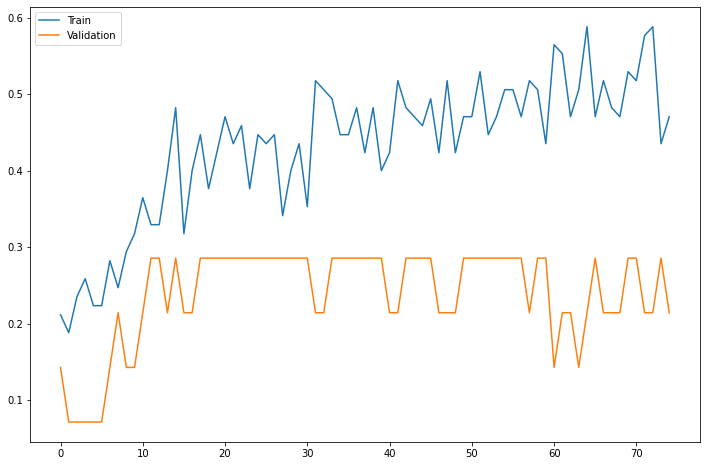

In [41]:
plt.figure(figsize=(12,8))
plt.plot(acc_train, label="Train")
plt.plot(acc_val, label="Validation")
plt.legend()
plt.show()

## III. Visualize the embeddings

In [42]:
labels = []

for k in range(len(label)):
    labels.append(np.argmax(np.array(label)[k], axis=1))

In [43]:
labels

[array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6]),
 array([5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5]),
 array([5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [44]:
list_emb

[array([[ 9.8151058e-02,  3.7320483e-01,  1.6971123e-01],
        [ 1.7158052e-01,  2.0157313e-01,  2.8762472e-01],
        [ 1.9937512e-01,  2.3322286e-01,  2.5706539e-01],
        [ 6.1976999e-02,  2.3751353e-01,  1.8914568e-01],
        [ 2.1167046e-01,  5.2218556e-01,  4.5173427e-01],
        [ 5.1018888e-01,  4.6458089e-01,  6.8471646e-01],
        [ 3.0340999e-01,  1.5053511e-01,  6.1126518e-01],
        [ 3.9040327e-02,  7.1972296e-02,  2.7114171e-01],
        [ 6.2086016e-02, -1.8958569e-02,  3.0153811e-01],
        [ 2.3722059e-01,  1.9449691e-01,  3.9183134e-01],
        [ 1.4424291e-01,  2.3305120e-01,  2.5923699e-01],
        [ 7.4560612e-02,  2.4649847e-01,  2.4261609e-01],
        [ 6.2086016e-02, -1.8958569e-02,  3.0153811e-01],
        [ 3.1754589e-01, -8.5204780e-02,  3.9323092e-01],
        [ 1.7806768e-02,  3.6373627e-01,  1.4059177e-01],
        [ 1.6326836e-01,  1.8728003e-01,  2.2156250e-01],
        [ 2.8667390e-01,  2.2297239e-01, -2.1761537e-02],
        [ 2.05

In [45]:
mat = np.matrix(list_emb[0])
for k in range(1, epoch):
    mat = np.concatenate([mat, np.matrix(list_emb[k])])

In [46]:
pca = PCA(n_components=3)
mat_pc = pca.fit_transform(mat)

In [47]:
mat_pc

array([[-0.2750578 ,  0.31361008,  0.06405886],
       [-0.20971252,  0.10498288,  0.03311129],
       [-0.18652229,  0.14830723,  0.01599721],
       ...,
       [-0.73467517, -0.6511943 , -0.08916925],
       [-1.0683737 , -0.07604507, -0.14601971],
       [-0.66241455, -0.06273036, -0.31691295]], dtype=float32)

In [48]:
mat.shape

(8436, 3)

In [49]:
mat_pc.shape

(8436, 3)

In [50]:
len(list(list_emb))

75

In [51]:
if hidden == 3 :
    df_list = []
    k = 0 

    df_list.append([0, "Nobody", 0, 0, 0, "0"])
    df_list.append([0, "Nobody", 0, 0, 0, "1"])
    df_list.append([0, "Nobody", 0, 0, 0, "2"])
    df_list.append([0, "Nobody", 0, 0, 0, "3"])
    df_list.append([0, "Nobody", 0, 0, 0, "4"])
    df_list.append([0, "Nobody", 0, 0, 0, "5"])
    df_list.append([0, "Nobody", 0, 0, 0, "6"])

    for i in range(epochs):
        for k in range(len(list_emb[i])):
            df_list.append([i, spk_dict[k], list_emb[i][k][0], list_emb[i][k][1], list_emb[i][k][2], str(labels[i][k])])

else:
    df_list = []
    k = 0 

    df_list.append([0, "Nobody", 0, 0, 0, "0"])
    df_list.append([0, "Nobody", 0, 0, 0, "1"])
    df_list.append([0, "Nobody", 0, 0, 0, "2"])
    df_list.append([0, "Nobody", 0, 0, 0, "3"])
    df_list.append([0, "Nobody", 0, 0, 0, "4"])
    df_list.append([0, "Nobody", 0, 0, 0, "5"])
    df_list.append([0, "Nobody", 0, 0, 0, "6"])

    for i in range(epochs):
        for k in range(len(list_emb[i])):
            df_list.append([i, spk_dict[k], mat_pc[i*k + i][0], mat_pc[i*k + i][1], mat_pc[i*k + i][2], str(labels[i][k])])

In [52]:
df = pd.DataFrame(df_list)
df.columns = ["Epoch", "Character", "X", "Y", "Z", "Label"]
df['Size'] = 1
df.head()

Epoch Character    X    Y    Z Label  Size
0      0    Nobody  0.0  0.0  0.0     0     1
1      0    Nobody  0.0  0.0  0.0     1     1
2      0    Nobody  0.0  0.0  0.0     2     1
3      0    Nobody  0.0  0.0  0.0     3     1
4      0    Nobody  0.0  0.0  0.0     4     1

In [53]:
df['Label'].value_counts()

6    5341
3    1298
4    1266
5     463
1     163
2      25
0       1
Name: Label, dtype: int64

In [54]:
max(df['X']), min(df['X'])

(2.768317461013794, -1.650965929031372)

In [55]:
max(df['Y']), min(df['Y'])

(3.237628698348999, -1.3570759296417236)

In [56]:
max(df['Z']), min(df['Z'])

(2.0875816345214844, -1.0309572219848633)

In [57]:
df.shape

(8557, 7)

In [58]:
fig = px.scatter_3d(df, x="X", y="Y", z="Z", hover_data = ["Character"], animation_frame="Epoch", color="Label", size_max=3) #size="Size", size_max=1,
fig.update_layout(title="Embedding evolution over epochs")
fig.show()